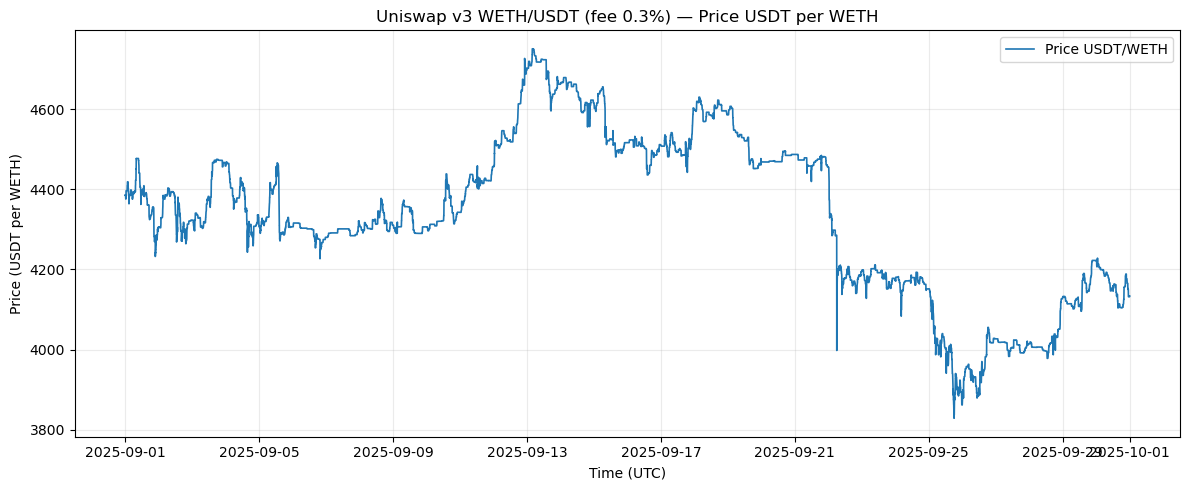

{'pool': '0x4e68ccd3e89f51c3074ca5072bbac773960dfa36', 'token0': 'WETH (18)', 'token1': 'USDT (6)'}
           evt_block_time              sqrtPriceX96
2025-09-01 00:00:23+00:00 5246665246043311943857518
2025-09-01 00:12:47+00:00 5246661594975338163722432
2025-09-01 00:12:47+00:00 5246662773835458761920809


In [8]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

BASE = Path(os.getcwd())
SWAPS_CSV = BASE / 'dune_pipeline' / 'swaps_2025_09_01_to_2025_10_01_eth_usdt_0p3.csv'
TOKENS_CSV = BASE / 'dune_pipeline' / 'token_metadata_eth_usdt_0p3.csv'
POOL_CFG_CSV = BASE / 'dune_pipeline' / 'pool_config_eth_usdt_0p3.csv'

Q96 = 2 ** 96

# Load metadata
pool_cfg = pd.read_csv(POOL_CFG_CSV)
assert len(pool_cfg) == 1, 'Expected a single pool config row'
pool_address = pool_cfg.loc[0, 'pool']
token0_addr = pool_cfg.loc[0, 'token0'].lower()
token1_addr = pool_cfg.loc[0, 'token1'].lower()

# token metadata: address -> (symbol, decimals)
tokens_df = pd.read_csv(TOKENS_CSV)
tokens_df['contract_address'] = tokens_df['contract_address'].str.lower()
addr_to_decimals = dict(zip(tokens_df['contract_address'], tokens_df['decimals']))
addr_to_symbol = dict(zip(tokens_df['contract_address'], tokens_df['symbol']))

# Resolve decimals and symbols for token0/token1
try:
    decimals0 = int(addr_to_decimals[token0_addr])
    decimals1 = int(addr_to_decimals[token1_addr])
    symbol0 = addr_to_symbol[token0_addr]
    symbol1 = addr_to_symbol[token1_addr]
except KeyError as e:
    raise RuntimeError(f'Missing token metadata for address: {e}')

# Load swaps
swaps = pd.read_csv(SWAPS_CSV)
swaps['evt_block_time'] = pd.to_datetime(swaps['evt_block_time'], utc=True)
swaps = swaps.sort_values('evt_block_time').reset_index(drop=True)

# Compute price per Uniswap v3 math:
# price_token1_per_token0 = (sqrtPriceX96 / Q96)^2 * 10^(decimals0 - decimals1)
# This yields human-readable price of token1 in terms of token0.
sqrt_x96 = swaps['sqrtPriceX96'].astype('float64')
price_1_per_0 = (sqrt_x96 / Q96) ** 2 * (10 ** (decimals0 - decimals1))

# Prepare plotting data
ts = swaps['evt_block_time']
amount1_human = swaps['amount1'].astype('float64') / (10 ** decimals1)
trade_size = amount1_human.abs()

# Scale marker size to keep plot readable
# Use square-root scaling to compress extremes
marker_size = 20 + 5 * np.sqrt(trade_size.clip(upper=np.percentile(trade_size, 99)))

# Color by trade direction: token1 to pool (positive) vs from pool (negative)
colors = np.where(amount1_human >= 0, '#2ca02c', '#d62728')

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(ts, price_1_per_0, color='#1f77b4', linewidth=1.2, label=f'Price {symbol1}/{symbol0}')

ax.set_title(f'Uniswap v3 {symbol0}/{symbol1} (fee 0.3%) — Price {symbol1} per {symbol0}')
ax.set_xlabel('Time (UTC)')
ax.set_ylabel(f'Price ({symbol1} per {symbol0})')
ax.grid(True, alpha=0.25)
ax.legend(loc='best')
plt.tight_layout()
plt.show()

# Display a small head for verification
print({'pool': pool_address, 'token0': f"{symbol0} ({decimals0})", 'token1': f"{symbol1} ({decimals1})"})
print(swaps[['evt_block_time', 'sqrtPriceX96']].head(3).to_string(index=False))
